In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.08
set_session(tf.Session(config=config))

import keras
from matplotlib import pyplot as pl
import numpy as np
import gzip
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.layers.core import Dense, Dropout, Flatten, Activation
from keras.models import Model
from keras.optimizers import RMSprop
from keras.utils import np_utils
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn import metrics
%matplotlib inline

Using TensorFlow backend.


In [2]:
def extract_data(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(28 * 28 * num_images)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(num_images, 28,28)
        return data

def extract_labels(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
        return labels

# Create dictionary of target classes
label_dict = {
 0: 'A',
 1: 'B',
 2: 'C',
 3: 'D',
 4: 'E',
 5: 'F',
 6: 'G',
 7: 'H',
 8: 'I',
 9: 'J',
}

In [3]:
train_data = extract_data('train-images-idx3-ubyte.gz', 60000)
test_data = extract_data('t10k-images-idx3-ubyte.gz', 10000)

train_labels = extract_labels('train-labels-idx1-ubyte.gz',60000)
test_labels = extract_labels('t10k-labels-idx1-ubyte.gz',10000)

X_train = train_data.reshape(-1, 28,28, 1)  # add grey channel
X_test = test_data.reshape(-1, 28,28, 1)

n_classes = 10
Y_train = np_utils.to_categorical(train_labels, n_classes) # 1-hot
Y_test = np_utils.to_categorical(test_labels, n_classes)
print(Y_train[:10])

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


In [4]:
# Shape of training set
print("Training set (images) shape: {shape}".format(shape=X_train.shape))
# Shape of test set
print("Test set (images) shape: {shape}".format(shape=X_test.shape))
# Type of data - should be float32
print('data type: ', X_train.dtype, X_test.dtype)

Training set (images) shape: (60000, 28, 28, 1)
Test set (images) shape: (10000, 28, 28, 1)
data type:  float32 float32


Text(0.5, 1.0, '(Label: D)')

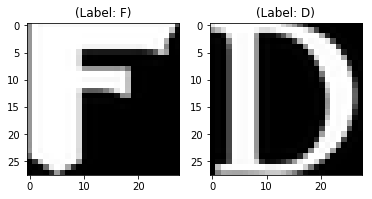

In [5]:
# Display the first image in training data
pl.subplot(121)
curr_img = np.reshape(X_train[0], (28,28))
curr_lbl = train_labels[0]
pl.imshow(curr_img, cmap='gray')
pl.title("(Label: " + str(label_dict[curr_lbl]) + ")")

# Display the first image in testing data
pl.subplot(122)
curr_img = np.reshape(X_test[0], (28,28))
curr_lbl = test_labels[0]
pl.imshow(curr_img, cmap='gray')
pl.title("(Label: " + str(label_dict[curr_lbl]) + ")")

In [6]:
# rescale the data in range 0-1
X_train = X_train / 255.0
X_test = X_test / 255.0

## Create a shallow MLP encoder

In [7]:
# STARTING FROM HERE, COMPLETE THE CODE WHERE YOU SEE ...
# size of our encoded representation
encoding_dim = 32  # this is the number of neurons you chose to encode

# define input layer, encoded layer and decoded layer
input_img = Input(shape=(784,))
encoded = Dense(encoding_dim,activation='relu')(input_img)
decoded = Dense(784,activation='sigmoid')(encoded)

# define autoencoder model 
autoencoder = Model(inputs=input_img,outputs=decoded)
encoder = Model(inputs=input_img,outputs=encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))

# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]

# create the decoder model
decoder = Model(inputs=encoded_input,outputs=decoder_layer(encoded_input))

In [8]:
# compile the network
autoencoder.compile(optimizer='rmsprop',loss='mean_squared_error',metrics=['accuracy'])

In [9]:
# for visualiztion
def plot_result(x_test,decoded_imgs):
    n = 10
    pl.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = pl.subplot(2, n, i + 1)
        pl.imshow(x_test[i].reshape(28, 28))
        pl.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = pl.subplot(2, n, i + 1 + n)
        pl.imshow(decoded_imgs[i].reshape(28, 28))
        pl.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    pl.show()

In [10]:
X_train_flat = X_train.reshape(60000,784)
X_test_flat = X_test.reshape(10000,784)

In [11]:
# train the network
B=256
E=15
log = autoencoder.fit(X_train_flat,X_train_flat,batch_size=B,epochs=E,verbose=1,validation_data=(X_test_flat,X_test_flat))

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 4s 75us/step - loss: 0.1033 - acc: 0.0012 - val_loss: 0.0628 - val_acc: 0.0011
Epoch 2/15
60000/60000 [==============================] - 1s 21us/step - loss: 0.0603 - acc: 0.0017 - val_loss: 0.0479 - val_acc: 0.0017
Epoch 3/15
60000/60000 [==============================] - 1s 21us/step - loss: 0.0496 - acc: 0.0013 - val_loss: 0.0417 - val_acc: 0.0012
Epoch 4/15
60000/60000 [==============================] - 1s 20us/step - loss: 0.0439 - acc: 0.0011 - val_loss: 0.0374 - val_acc: 0.0014
Epoch 5/15
60000/60000 [==============================] - 1s 19us/step - loss: 0.0405 - acc: 0.0013 - val_loss: 0.0333 - val_acc: 0.0011
Epoch 6/15
60000/60000 [==============================] - 1s 20us/step - loss: 0.0382 - acc: 0.0015 - val_loss: 0.0340 - val_acc: 0.0012
Epoch 7/15
60000/60000 [==============================] - 1s 20us/step - loss: 0.0366 - acc: 0.0018 - val_loss: 0.0300 - val_acc

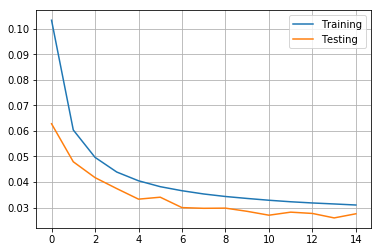

In [12]:
pl.plot(log.history['loss'], label='Training')
pl.plot(log.history['val_loss'], label='Testing')
pl.legend()
pl.grid()

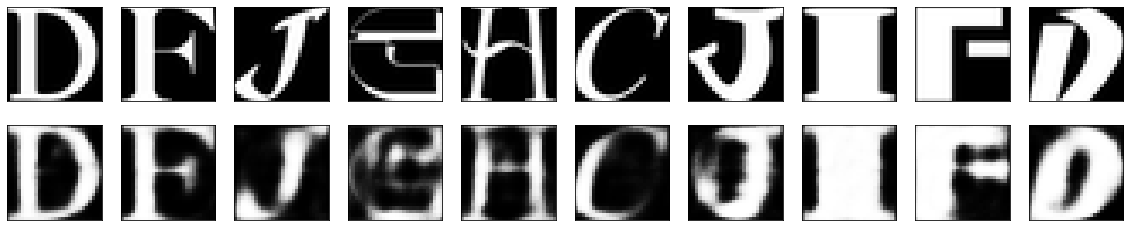

In [13]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(X_test_flat)
decoded_imgs = decoder.predict(encoded_imgs)
plot_result(X_test_flat,decoded_imgs)

### Use the encoded features to train another classifier

In [14]:
X_train_feat = encoder.predict(X_train_flat)
X_test_feat = encoder.predict(X_test_flat)

# Normalization (standardization) of training and test sets
scaler = StandardScaler()  
scaler.fit(X_train_feat)
X_train_feat = scaler.transform(X_train_feat)  
X_test_feat = scaler.transform(X_test_feat)

print(X_train_feat.shape)
print(Y_train.shape)
print(X_test_feat.shape)
print(Y_test.shape)

(60000, 32)
(60000, 10)
(10000, 32)
(10000, 10)


In [15]:
# using the features
clf = SVC(kernel='linear', cache_size=7000)
clf.fit(X_train_feat, train_labels)

SVC(C=1.0, cache_size=7000, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [16]:
y_pred = clf.predict(X_test_feat)

# Print classification results with confusion matrix
print("Classification report for classifier %s:\n%s\n" %
      (clf, metrics.classification_report(test_labels, y_pred)))
# print("\nConfusion matrix:\n%s" % metrics.confusion_matrix(test_labels, y_pred))

Classification report for classifier SVC(C=1.0, cache_size=7000, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

          0       0.90      0.90      0.90      1000
          1       0.90      0.87      0.88      1000
          2       0.91      0.92      0.91      1000
          3       0.91      0.90      0.91      1000
          4       0.91      0.88      0.90      1000
          5       0.91      0.93      0.92      1000
          6       0.88      0.88      0.88      1000
          7       0.90      0.89      0.89      1000
          8       0.87      0.86      0.86      1000
          9       0.85      0.93      0.89      1000

avg / total       0.90      0.90      0.90     10000




## Create a conv autoencoder

In [17]:
input_img = Input(shape=X_train.shape[1:])
# encoder
conv1 = Conv2D(32,kernel_size=3,activation='relu',padding='same')(input_img) #28 x 28 x 32
pool1 = MaxPooling2D(pool_size=(2,2))(conv1) #14 x 14 x 32
conv2 = Conv2D(64,kernel_size=3,activation='relu',padding='same')(pool1) #14 x 14 x 64
pool2 = MaxPooling2D(pool_size=(2,2))(conv2)  #7 x 7 x 64
conv3 = Conv2D(128,kernel_size=3,activation='relu',padding='same')(pool2) #7 x 7 x 128 (small and thick)
# decoder
conv4 = Conv2D(128,kernel_size=3,activation='relu',padding='same')(conv3) #7 x 7 x 128
up1 =  UpSampling2D(size=(2,2))(conv4) # 14 x 14 x 128 (UpSampling2D())
conv5 = Conv2D(64,kernel_size=3,activation='relu',padding='same')(up1) # 14 x 14 x 64
up2 = UpSampling2D(size=(2,2))(conv5) # 28 x 28 x 64
decoded = Conv2D(1,kernel_size=3,activation='relu',padding='same')(up2) # 28 x 28 x 1
# autoencoder
autoencoder = Model(inputs=input_img, outputs=decoded)
autoencoder.compile(optimizer='rmsprop',loss='mean_squared_error',metrics=['accuracy'])
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 128)         147584    
__________

In [18]:
log = autoencoder.fit(X_train,X_train,batch_size=128,epochs=15,verbose=1,validation_data=(X_test,X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 16s 272us/step - loss: 0.0504 - acc: 0.5735 - val_loss: 0.0199 - val_acc: 0.6097
Epoch 2/15
60000/60000 [==============================] - 14s 226us/step - loss: 0.0122 - acc: 0.5943 - val_loss: 0.0068 - val_acc: 0.6103
Epoch 3/15
60000/60000 [==============================] - 14s 226us/step - loss: 0.0081 - acc: 0.5948 - val_loss: 0.0061 - val_acc: 0.6106
Epoch 4/15
60000/60000 [==============================] - 14s 226us/step - loss: 0.0063 - acc: 0.5950 - val_loss: 0.0050 - val_acc: 0.6106
Epoch 5/15
60000/60000 [==============================] - 14s 226us/step - loss: 0.0053 - acc: 0.5951 - val_loss: 0.0041 - val_acc: 0.6108
Epoch 6/15
60000/60000 [==============================] - 14s 225us/step - loss: 0.0046 - acc: 0.5952 - val_loss: 0.0030 - val_acc: 0.6108
Epoch 7/15
60000/60000 [==============================] - 14s 226us/step - loss: 0.0042 - acc: 0.5952 - val_loss: 0.

### Predict on test data

In [19]:
decoded_imgs = autoencoder.predict(X_test, verbose=1)
print(decoded_imgs.shape)

10000/10000 [==============================] - 2s 157us/step
(10000, 28, 28, 1)


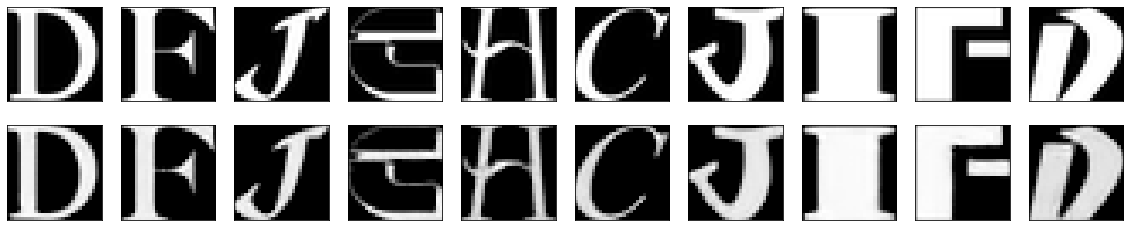

In [20]:
plot_result(X_test_flat,decoded_imgs)

## Denoising autoencoder
First add some noise.

In [ ]:
noise_factor = 0.4 #chose a noise factor between 0.0 and 1.0
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)
X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

In [ ]:
pl.figure(figsize=[5,5])

# Display the first image in training data
pl.subplot(121)
curr_img = np.reshape(X_train_noisy[1], (28,28))
pl.imshow(curr_img, cmap='gray')

# Display the first image in testing data
pl.subplot(122)
curr_img = np.reshape(X_test_noisy[1], (28,28))
pl.imshow(curr_img, cmap='gray')

In [ ]:
# REDEFINE HERE A CONV AUTOENCODER FOR THE DENOISING WITH A SIMILAR ARCHITECTURE
input_img = Input(shape=X_train.shape[1:])
# encoder
conv1 = Conv2D(32,kernel_size=3,activation='relu',padding='same')(input_img) #28 x 28 x 32
pool1 = MaxPooling2D(pool_size=(2,2))(conv1) #14 x 14 x 32
conv2 = Conv2D(64,kernel_size=3,activation='relu',padding='same')(pool1) #14 x 14 x 64
pool2 = MaxPooling2D(pool_size=(2,2))(conv2)  #7 x 7 x 64
conv3 = Conv2D(128,kernel_size=3,activation='relu',padding='same')(pool2) #7 x 7 x 128 (small and thick)
# decoder
conv4 = Conv2D(128,kernel_size=3,activation='relu',padding='same')(conv3) #7 x 7 x 128
up1 =  UpSampling2D(size=(2,2))(conv4) # 14 x 14 x 128 (UpSampling2D())
conv5 = Conv2D(64,kernel_size=3,activation='relu',padding='same')(up1) # 14 x 14 x 64
up2 = UpSampling2D(size=(2,2))(conv5) # 28 x 28 x 64
decoded = Conv2D(1,kernel_size=3,activation='relu',padding='same')(up2) # 28 x 28 x 1
# autoencoder
autoencoder = Model(inputs=input_img, outputs=decoded)
autoencoder.compile(optimizer='rmsprop',loss='mean_squared_error',metrics=['accuracy'])
autoencoder.summary()

In [ ]:
# train on the noisy images and use as target the original clean images
log = autoencoder.fit(X_train_noisy, X_train, batch_size=128, epochs=1,
                        verbose=1, validation_data=(X_test_noisy, X_test))

In [ ]:
decoded_imgs = autoencoder.predict(X_test_noisy, verbose=1)
print(decoded_imgs.shape)

In [ ]:
plot_result(X_test_noisy,decoded_imgs)